In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
import os
import random
import time
import copy
import numpy as np
%matplotlib inline

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.6.0
Torchvision Version:  0.7.0


# Data

In [4]:
data_dir = "./data"
resize = [224, 224]

# Veličina batch-a za trening
batch_size = 128

# Broja epoha za treniranje
num_epochs = 20

# Ako je parametar False cijeli model se finetune-a, a ako je True
# samo se zadnji sloj trenira
feature_extract = False

## Kreiranje validacijskog skupa

In [5]:
PATH ="./data/train/"
VAL_PATH = "./data/val/"
classes = [os.path.basename(x) for x in glob.glob(PATH + "*")]

val_size_percent = 0.2
for folder in classes:
    path_from = PATH + folder + "/*"
    path_to = VAL_PATH + folder + "/"
    
    num_images = len(glob.glob(path_from))
    val_images = np.random.choice(glob.glob(path_from), size=max(1, int(val_size_percent * num_images)), replace=False)

    for img in val_images:
        move_to_path = path_to + os.path.basename(img)
        if not os.path.exists(os.path.dirname(path_to)):
                os.makedirs(os.path.dirname(path_to))
        #os.rename(img, move_to_path)

## Data Loader

In [27]:
# Data augmentacija i normalizacija za treniranje
# Kod validacijskog i testnog seta koristi se samo normalizacija
# std [0.229, 0.224, 0.225]
# mean [0.485, 0.456, 0.406]
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(resize),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(90),
        #transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(resize),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(resize),
        #ransforms.FiveCrop(resize),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Kreiranje trening, test i valdiacijskog dataseta
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
# Kreiranje dataloadera
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, 
                                                   shuffle=True, pin_memory=True, num_workers=4) 
                    for x in ['train', 'val', 'test']}

# Treniranje na GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

print("Podaci su uspješno učitani!")

Podaci su uspješno učitani!


## Eksploracija dataseta

In [7]:
num_classes = len(image_datasets["train"].classes)

print("Broj slika u trening skupu: ", len(image_datasets['train']))
print("Broj slika u validacijskom skupu: ", len(image_datasets['val']))
print("Broj slika u testnom skupu: ", len(image_datasets['test']))
print("Ukupan broj klasa: ", num_classes)

Broj slika u trening skupu:  33991
Broj slika u validacijskom skupu:  8456
Broj slika u testnom skupu:  2200
Ukupan broj klasa:  76


In [8]:
# Eksploracija dataseta, testiranje da li su klase balansirane
from collections import Counter

tr = Counter(image_datasets["train"].targets)
vl = Counter(image_datasets["val"].targets)
tst = Counter(image_datasets["test"].targets)

for c in image_datasets["train"].classes:
    if c not in image_datasets["test"].classes:
        print("Klasa nije u testnom setu: ", c)

print("Odnos broja slika datih klasa u testnom/trening skupu")
for i in range (len(tr)):
    print("Odnos klase {:d}: {:.4f}".format(i, tst[i] / tr[i]))
print("Odnos veličine testnog i trening skupa: %.4f %%" % (100 * len(image_datasets['test']) / len(image_datasets['train'])))

Odnos broja slika datih klasa u testnom/trening skupu
Odnos klase 0: 0.0638
Odnos klase 1: 0.0556
Odnos klase 2: 0.0643
Odnos klase 3: 0.0658
Odnos klase 4: 0.0595
Odnos klase 5: 0.0658
Odnos klase 6: 0.0652
Odnos klase 7: 0.0662
Odnos klase 8: 0.0657
Odnos klase 9: 0.0637
Odnos klase 10: 0.0632
Odnos klase 11: 0.0632
Odnos klase 12: 0.0651
Odnos klase 13: 0.0650
Odnos klase 14: 0.0633
Odnos klase 15: 0.0632
Odnos klase 16: 0.0621
Odnos klase 17: 0.0651
Odnos klase 18: 0.0657
Odnos klase 19: 0.0661
Odnos klase 20: 0.0652
Odnos klase 21: 0.0633
Odnos klase 22: 0.0615
Odnos klase 23: 0.0571
Odnos klase 24: 0.0652
Odnos klase 25: 0.0646
Odnos klase 26: 0.0655
Odnos klase 27: 0.0659
Odnos klase 28: 0.0648
Odnos klase 29: 0.0000
Odnos klase 30: 0.0610
Odnos klase 31: 0.0657
Odnos klase 32: 0.0654
Odnos klase 33: 0.0649
Odnos klase 34: 0.0618
Odnos klase 35: 0.0561
Odnos klase 36: 0.0643
Odnos klase 37: 0.0649
Odnos klase 38: 0.0566
Odnos klase 39: 0.0526
Odnos klase 40: 0.0492
Odnos klase 4

0:  1205_bio_omogeneizzato 1:  1206_soft_ice_cream 2:  1747_pane_ai_semi_di_zucca 3:  3073_other-classifier 4:  3233_mackerel_salad 5:  785_bottled_water 6:  786_pane_kaiser 7:  787_daim_cake 8:  788_soft_drink 9:  789_grissini 10:  790_cracker 11:  791_chocolate 12:  792_sauce_pack 13:  793_fruit_mash 14:  794_chips_mushroom 15:  795_chips_pepper_and_leek 16:  796_bio_lemonade 17:  797_princess_cake 18:  798_drink_lingoberry 19:  801_fries 20:  803_munsbit_yellow 21:  817_gattopardo 22:  829_cheese_plate 23:  830_vegetable_patty_zucchine 24:  831_vegetable_patty_pumpkin 25:  832_vegetable_medallion 26:  833_vegetable_puff_pastry 27:  834_dessert_glass 28:  835_arancino 29:  836_dessert_whipped_cream_-_monoporzione 30:  837_blueberry-rasperry_cheesecake 31:  838_fruit_glass 32:  839_cheesecake 33:  840_bakery 34:  841_focaccia 35:  842_wine_glass 36:  843_wine_caraffa_0,5l 37:  844_munsbit_green 38:  845_munsbit_pink 39:  846_munsbit_blue 40:  847_prosecco 41:  848_wine_ferghettina 42:

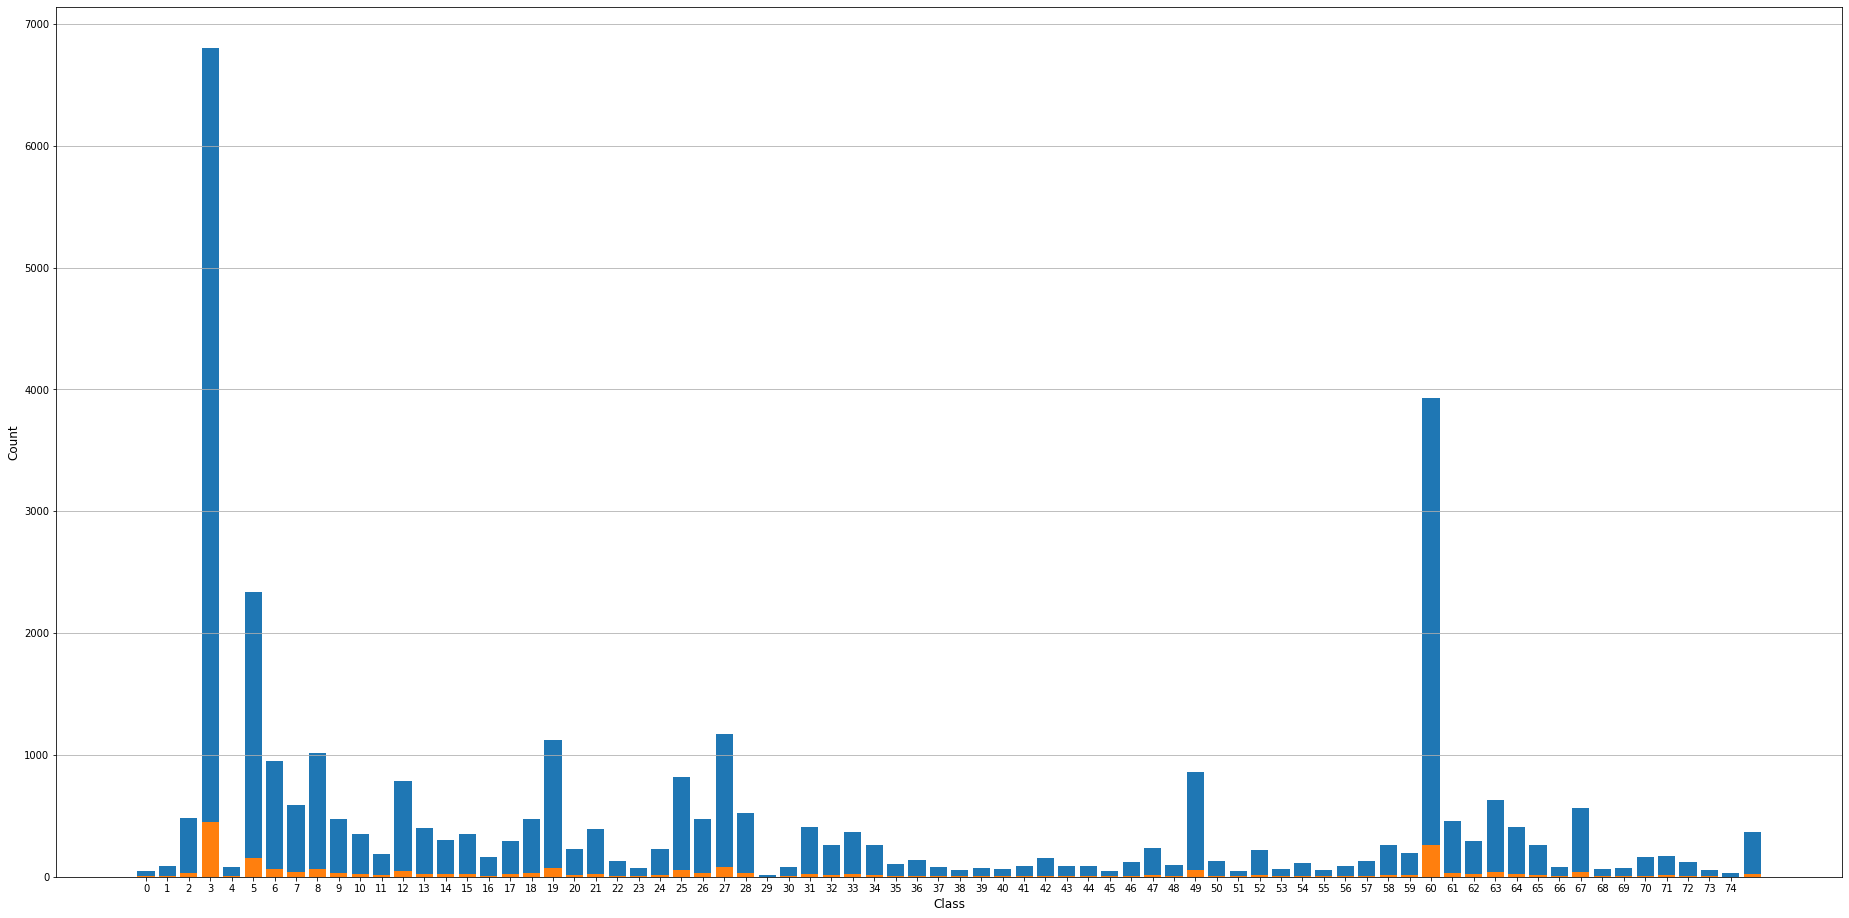

In [9]:
for i in ["train", "test"]:
    num_per_class = np.unique(image_datasets[i].targets, return_counts=True)
    plt.rcParams['figure.figsize'] = (32, 16)
    plt.bar(num_per_class[0], num_per_class[1])
    plt.xticks(np.arange(len(num_per_class[0])))
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.grid('on', axis='y')

for i in range(len(image_datasets["train"].classes)):
    print(str(i) + ": ", image_datasets["train"].classes[i], end=" ")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


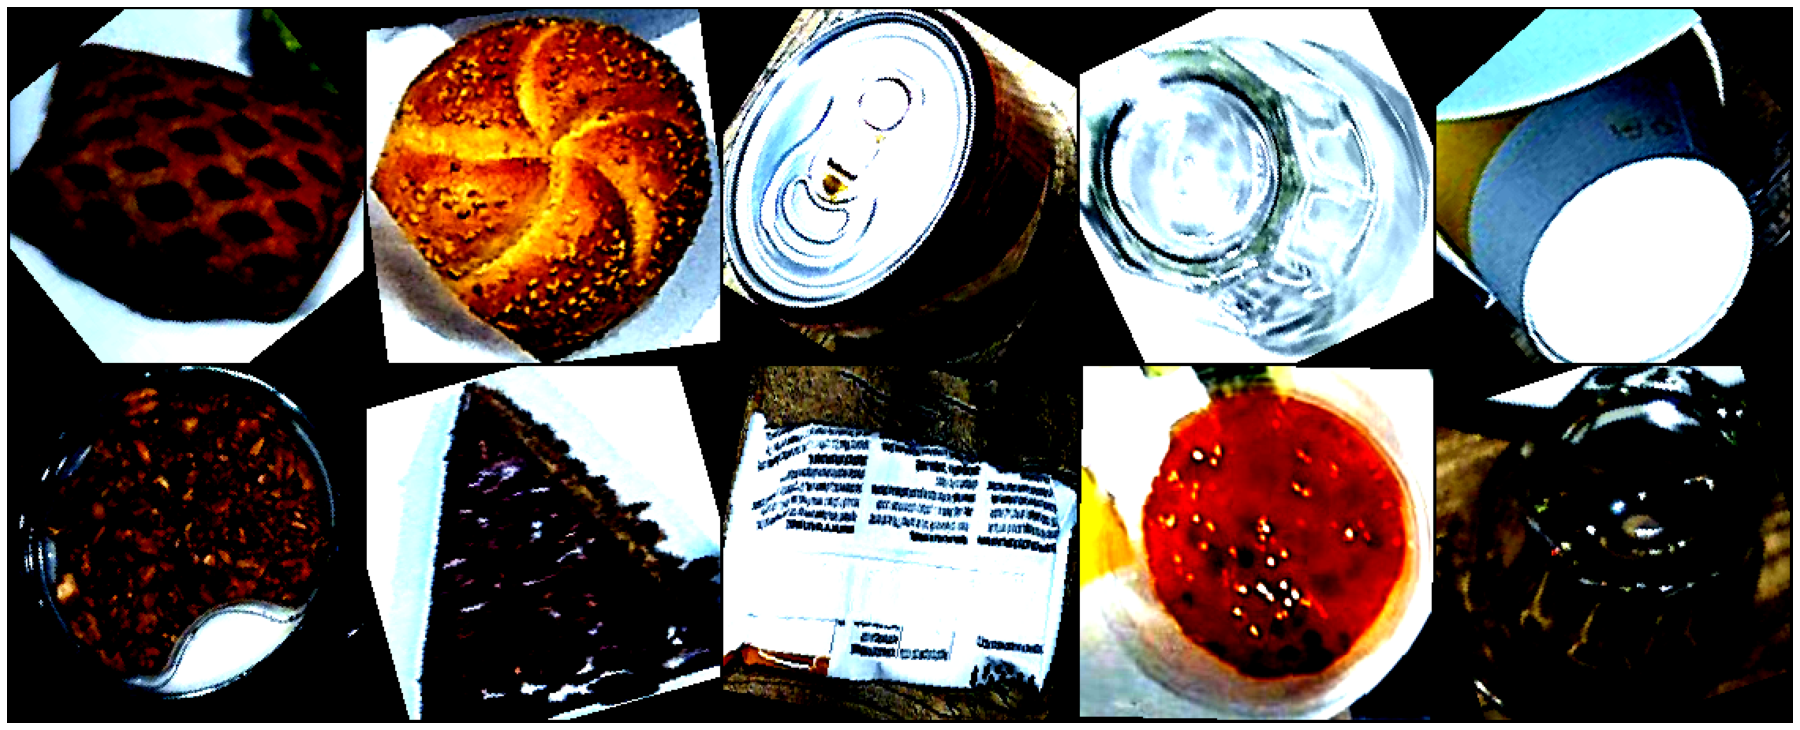

['833_vegetable_puff_pastry', '786_pane_kaiser', '856_soft_drink_cans', '876_glass_empty', '788_soft_drink', '902_cereal_glass', '787_daim_cake', '789_grissini', '3073_other-classifier', '876_glass_empty']


In [10]:
# Primjer slika iz trening skupa
def plot_image(tensors):
    plt.figure()
    plt.rcParams['figure.figsize'] = (32, 5)
    grid = make_grid(tensors, nrow=5)
    plt.imshow(grid.numpy().transpose((1,2,0)))
    plt.axis('off')
    plt.show()

num_pictures = 10
tensors = []
labels = []
n = len(image_datasets["train"])
for i in (range(num_pictures)):
    t = image_datasets["train"][random.randrange(n)]
    tensors.append(t[0])
    labels.append(image_datasets["train"].classes[t[1]])
plot_image(tensors)
print(labels)

# Konvolucijska mreža

## Kreiranje modela

In [11]:
# Finetune cijeli model ili samo zadnji sloj
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [12]:
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model = None
    input_size = 0

    """ Koristi se ResNet50 pretrenirani model na ImageNet datasetu """
    model = models.resnet50(pretrained=use_pretrained)
    set_parameter_requires_grad(model, feature_extract)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224

    if n_gpu > 1:  
        model = nn.DataParallel(model) # paralelizam
    return model, input_size

# Inicijalizacija modela
model, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)

print(model)

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

## Funkcija za treniranje

In [13]:
def train_model(model, dataloaders, criterion, optimizer, lr_scheduler, num_epochs=25):
    start = time.time()

    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []
    
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoha {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # trening mod
            else:
                model.eval()   # test mod

            running_loss = 0.0
            running_corrects = 0

            # Iteriranje kroz skup slika
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward faza
                with torch.set_grad_enabled(phase == 'train'):
                    # racunanje loss funkcije i izlaza iz modela
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    if(n_gpu > 1):
                        loss = loss.mean()
                    _, preds = torch.max(outputs, 1)

                    # backward faza i optimizacija, ukoliko je training mod
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistike
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # ukoliko opadne preciznost na validacijskom skupu smanji learning rate
            if phase == 'val' and epoch > 0 and epoch_acc < val_acc_history[-1]:
                lr_scheduler.step()
                
            # kopiranje najboljeg modela
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - start
    print('Trening završen za: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Najbolja preciznost (Acc) na validacijskom skupu: {:4f}'.format(best_acc))

    # ucitvanje najboljeg modela
    model.load_state_dict(best_model)
    return model, val_acc_history, val_loss_history, train_acc_history, train_loss_history

## Optimizer

In [14]:
model = model.to(device)

params_to_update = model.parameters()
print("Parametri modela za treniranje:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer = optim.Adam(params_to_update)
decay_rate = 0.95
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)

Parametri modela za treniranje:
	 module.conv1.weight
	 module.bn1.weight
	 module.bn1.bias
	 module.layer1.0.conv1.weight
	 module.layer1.0.bn1.weight
	 module.layer1.0.bn1.bias
	 module.layer1.0.conv2.weight
	 module.layer1.0.bn2.weight
	 module.layer1.0.bn2.bias
	 module.layer1.0.conv3.weight
	 module.layer1.0.bn3.weight
	 module.layer1.0.bn3.bias
	 module.layer1.0.downsample.0.weight
	 module.layer1.0.downsample.1.weight
	 module.layer1.0.downsample.1.bias
	 module.layer1.1.conv1.weight
	 module.layer1.1.bn1.weight
	 module.layer1.1.bn1.bias
	 module.layer1.1.conv2.weight
	 module.layer1.1.bn2.weight
	 module.layer1.1.bn2.bias
	 module.layer1.1.conv3.weight
	 module.layer1.1.bn3.weight
	 module.layer1.1.bn3.bias
	 module.layer1.2.conv1.weight
	 module.layer1.2.bn1.weight
	 module.layer1.2.bn1.bias
	 module.layer1.2.conv2.weight
	 module.layer1.2.bn2.weight
	 module.layer1.2.bn2.bias
	 module.layer1.2.conv3.weight
	 module.layer1.2.bn3.weight
	 module.layer1.2.bn3.bias
	 module.laye

# Trening

In [15]:
# Loss funkcija je CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Treniranje
model, val_acc_hist, val_loss_hist, train_acc_hist, train_loss_hist = train_model(model, dataloaders_dict, criterion, optimizer, 
                                             lr_scheduler, num_epochs=num_epochs)

Epoha 1/20
----------
train Loss: 0.4517 Acc: 0.8790
val Loss: 0.2035 Acc: 0.9354

Epoha 2/20
----------
train Loss: 0.1339 Acc: 0.9588
val Loss: 0.2554 Acc: 0.9372

Epoha 3/20
----------
train Loss: 0.0998 Acc: 0.9709
val Loss: 0.1250 Acc: 0.9613

Epoha 4/20
----------
train Loss: 0.0738 Acc: 0.9776
val Loss: 0.0502 Acc: 0.9834

Epoha 5/20
----------
train Loss: 0.0608 Acc: 0.9811
val Loss: 0.0774 Acc: 0.9762

Epoha 6/20
----------
train Loss: 0.0479 Acc: 0.9858
val Loss: 0.0502 Acc: 0.9849

Epoha 7/20
----------
train Loss: 0.0551 Acc: 0.9840
val Loss: 0.0575 Acc: 0.9834

Epoha 8/20
----------
train Loss: 0.0400 Acc: 0.9875
val Loss: 0.0338 Acc: 0.9909

Epoha 9/20
----------
train Loss: 0.0303 Acc: 0.9904
val Loss: 0.0452 Acc: 0.9859

Epoha 10/20
----------
train Loss: 0.0263 Acc: 0.9915
val Loss: 0.0197 Acc: 0.9948

Epoha 11/20
----------
train Loss: 0.0316 Acc: 0.9909
val Loss: 0.0675 Acc: 0.9808

Epoha 12/20
----------
train Loss: 0.0282 Acc: 0.9911
val Loss: 0.0557 Acc: 0.9843

E

## Save/Load model

In [33]:
MODEL_PATH = "./model/resnet50bn_multigpu_20_epochs.pt"
torch.save(model.state_dict(), MODEL_PATH)
#model.load_state_dict(torch.load(MODEL_PATH))

In [17]:
# Spasi loss i acc nizove
np.savetxt("./model/resnet50bn_multigpu_20_epochs_tr_acc.txt", train_acc_hist)
np.savetxt("./model/resnet50bn_multigpu_20_epochs_tr_loss.txt", train_loss_hist)
np.savetxt("./model/resnet50bn_multigpu_20_epochs_val_acc.txt", val_acc_hist)
np.savetxt("./model/resnet50bn_multigpu_20_epochs_val_loss.txt", val_loss_hist)

## Loss i preciznost na trening skupu tokom treniranja

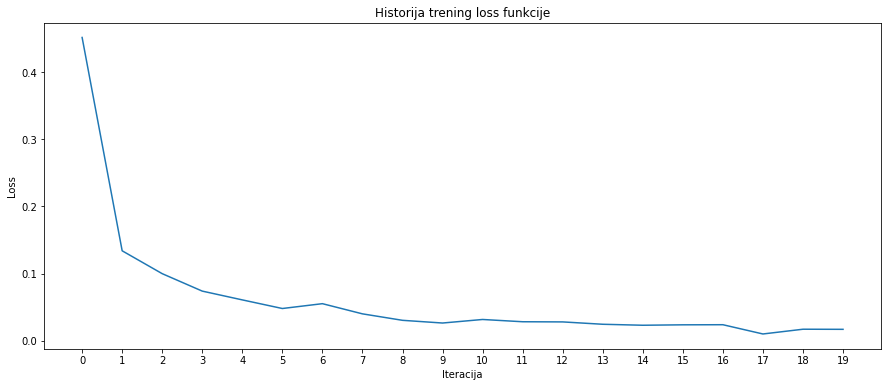

In [18]:
plt.title('Historija trening loss funkcije')
plt.plot(train_loss_hist)
plt.xlabel('Iteracija')
plt.ylabel('Loss')
plt.xticks(range(0,len(train_loss_hist)))
plt.gcf().set_size_inches(15, 6)
plt.show()

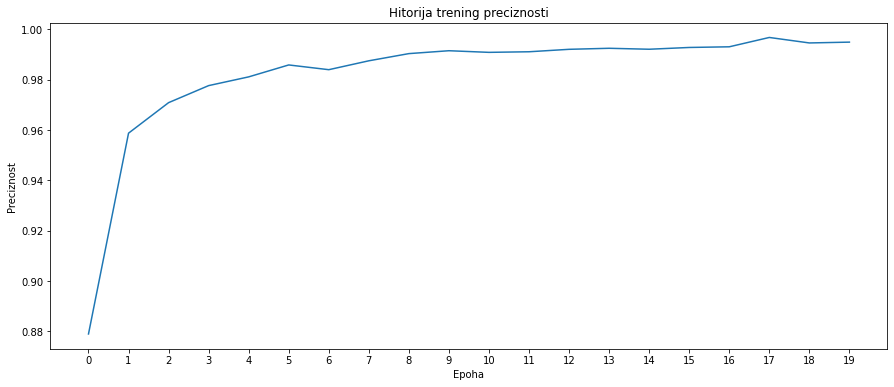

In [20]:
plt.title('Hitorija trening preciznosti')
plt.plot(train_acc_hist)
plt.xlabel('Epoha')
plt.ylabel('Preciznost')
plt.xticks(range(0,len(train_acc_hist)))
plt.gcf().set_size_inches(15, 6)
plt.show()

## Loss i preciznost na validacijskom skupu tokom treniranja

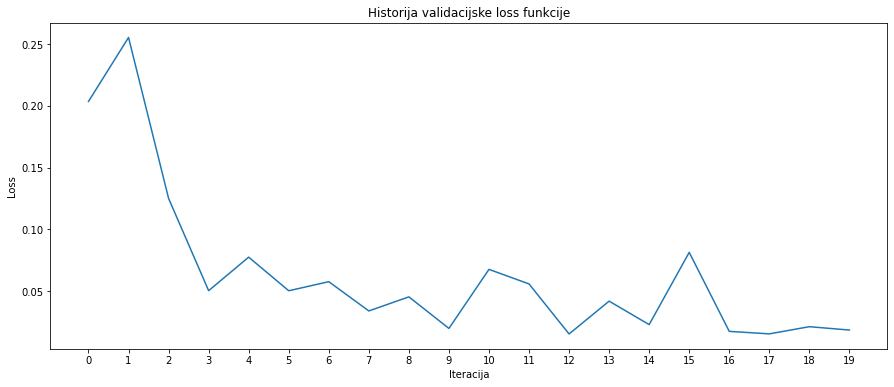

In [22]:
plt.title('Historija validacijske loss funkcije')
plt.plot(val_loss_hist)
plt.xlabel('Iteracija')
plt.ylabel('Loss')
plt.xticks(range(0,len(val_loss_hist)))
plt.gcf().set_size_inches(15, 6)
plt.show()

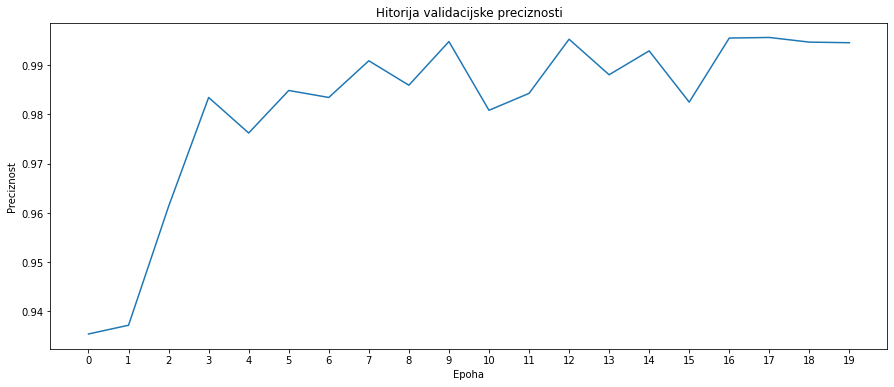

In [23]:
plt.title('Hitorija validacijske preciznosti')
plt.plot(val_acc_hist)
plt.xlabel('Epoha')
plt.ylabel('Preciznost')
plt.xticks(range(0,len(val_acc_hist)))
plt.gcf().set_size_inches(15, 6)
plt.show()

# Testiranje modela

In [24]:
correct = 0
total = 0
inference_time = []
model.eval()
with torch.no_grad():
    for inputs, labels in dataloaders_dict["test"]:
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        start = time.time()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        inference_time.append((time.time() - start) / labels.size(0))
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Preciznost modela na ' + str(total) + ' testnih slika: %.2f %%' % (
    100 * correct / total))

inference_time = np.mean(inference_time, dtype='float64')
print('Prosječni inference time: {:.0f} mikrosekundi'.format(inference_time * 1e6))

print("Broj pogrešnih predikcija: " + str(total - correct) + " / " + str(total))

Preciznost modela na 2200 testnih slika: 99.45 %
Prosječni inference time: 360 mikrosekundi
Broj pogrešnih predikcija: 12 / 2200


## Vizualizacija testnog skupa

In [22]:
test_size = 10
test_tensors = []
test_labels = []
test_predicted = []

n = len(image_datasets["test"])
for i in (range(test_size)):
    t = image_datasets["test"][random.randrange(n)]
    test_tensors.append(t[0])
    test_labels.append(image_datasets["test"].classes[t[1]])
    
    _, predicted = torch.max(model(t[0].unsqueeze(0).to(device)).data, 1)
    test_predicted.append(image_datasets["test"].classes[predicted.item()])
    
plot_image(test_tensors)
print("Tačna klasa: ", test_labels)
print()
print("Predikcija klase: ", test_predicted)
print()
test_correct = (np.array(test_labels) == np.array(test_predicted)).sum()
print('Preciznost : %.2f %%' % (100 * test_correct / test_size))

TypeError: pic should be PIL Image or ndarray. Got <class 'tuple'>

# Treniranje modela koji samo trenira zadnji sloj mreže

In [31]:
# Inicijalizacija modela
feature_extract = True
model_feature, input_size = initialize_model(num_classes, feature_extract, use_pretrained = True)
model_feature = model_feature.to(device)

params_to_update = model_feature.parameters()
print("Parametri modela za treniranje:")
params_to_update = []
for name,param in model_feature.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
        
optimizer = optim.Adam(params_to_update)
decay_rate = 0.95
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)

# Loss funkcija je CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Treniranje
model_feature, val_acc_hist, val_loss_hist, train_acc_hist, train_loss_hist = train_model(model_feature, dataloaders_dict, criterion, optimizer, 
                                             lr_scheduler, num_epochs=num_epochs)

Parametri modela za treniranje:
	 module.fc.weight
	 module.fc.bias
Epoha 1/20
----------
train Loss: 0.7119 Acc: 0.8549
val Loss: 0.2642 Acc: 0.9519

Epoha 2/20
----------
train Loss: 0.1688 Acc: 0.9653
val Loss: 0.1489 Acc: 0.9677

Epoha 3/20
----------
train Loss: 0.1140 Acc: 0.9743
val Loss: 0.1381 Acc: 0.9667

Epoha 4/20
----------
train Loss: 0.0884 Acc: 0.9798
val Loss: 0.0998 Acc: 0.9774

Epoha 5/20
----------
train Loss: 0.0773 Acc: 0.9805
val Loss: 0.0954 Acc: 0.9766

Epoha 6/20
----------
train Loss: 0.0645 Acc: 0.9837
val Loss: 0.0837 Acc: 0.9787

Epoha 7/20
----------
train Loss: 0.0572 Acc: 0.9854
val Loss: 0.0700 Acc: 0.9805

Epoha 8/20
----------
train Loss: 0.0557 Acc: 0.9860
val Loss: 0.0651 Acc: 0.9831

Epoha 9/20
----------
train Loss: 0.0506 Acc: 0.9868
val Loss: 0.0647 Acc: 0.9829

Epoha 10/20
----------
train Loss: 0.0470 Acc: 0.9864
val Loss: 0.0613 Acc: 0.9829

Epoha 11/20
----------
train Loss: 0.0446 Acc: 0.9878
val Loss: 0.0621 Acc: 0.9817

Epoha 12/20
-----

## Testiranje novog modela

In [32]:
correct = 0
total = 0
inference_time = []
model_feature.eval()
with torch.no_grad():
    for inputs, labels in dataloaders_dict["test"]:
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        start = time.time()
        outputs = model_feature(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        inference_time.append((time.time() - start) / labels.size(0))
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Preciznost modela na ' + str(total) + ' testnih slika: %.2f %%' % (
    100 * correct / total))

inference_time = np.mean(inference_time, dtype='float64')
print('Prosječni inference time: {:.0f} mikrosekundi'.format(inference_time * 1e6))

print("Broj pogrešnih predikcija: " + str(total - correct) + " / " + str(total))

Preciznost modela na 2200 testnih slika: 98.55 %
Prosječni inference time: 353 mikrosekundi
Broj pogrešnih predikcija: 32 / 2200
